In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb, log_mlflow
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml
import wandb

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/wandb/util.py:35: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, Mapping, Sequence


In [3]:
predictions_dict = {}

In [4]:
config_filename = 'uncer.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [5]:
timestamp = datetime.datetime.now()
output_folder = '../../misc/reports/{}'.format(timestamp.strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 0/10000 [00:00<?, ?it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_24122020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 181                 | 182                 | 183                 | 184                 | 185                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-24 00:00:00 | 2020-10-25 00:00:00 | 2020-10-26 00:00:00 | 2020-10-27 00:00:00 | 2020-10-28 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 249759.14           | 250955.0            | 252085.0            | 252886.0            | 254240.0   

  0%|          | 13/10000 [00:00<01:23, 119.67it/s]

The acceptance ratio is -------->  0.1166
The explored steps are -------->  553
The optimized steps are -------->  613


  0%|          | 13/10000 [00:00<01:20, 123.74it/s]

The acceptance ratio is -------->  0.1126
The explored steps are -------->  532
The optimized steps are -------->  594


 28%|██▊       | 2771/10000 [00:24<01:13, 97.72it/s] /Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:336: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
  0%|          | 15/10000 [00:00<01:07, 147.76it/s]

The acceptance ratio is -------->  0.1183
The explored steps are -------->  558
The optimized steps are -------->  625


100%|██████████| 10000/10000 [01:34<00:00, 105.97it/s]


The acceptance ratio is -------->  0.1213
The explored steps are -------->  560
The optimized steps are -------->  653


  1%|          | 11/2000 [00:00<00:19, 102.29it/s]

Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.088318701426422,
    'I_hosp_ratio': 1.1847120706909875,
    'P_fatal': 1.0155435285831351,
    'T_inc': 1.011400578777294,
    'T_inf': 1.010202160896635,
    'T_recov': 1.3259812724431366,
    'T_recov_fatal': 1.055711587573469,
    'gamma': 1.1009072777919837,
    'lockdown_R0': 1.0269737913682453}


100%|██████████| 2000/2000 [00:18<00:00, 106.01it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.9243590203146884), ('T_inc', 4.83590022940037), ('T_inf', 3.513477843806925), ('T_recov', 10.778933157863785), ('T_recov_fatal', 19.59637306249155), ('P_fatal', 0.025955214828337993), ('E_hosp_ratio', 0.14951749036936662), ('I_hosp_ratio', 0.42491255484264473), ('gamma', 0.012011072284738245)])


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 13/10000 [00:00<01:21, 122.71it/s]

Performing m2 fit ..
loading from ../../misc/cache/dataframes_ts_24122020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 184                 | 185                 | 186                 | 187                 | 188                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-27 00:00:00 | 2020-10-28 00:00:00 | 2020-10-29 00:00:00 | 2020-10-30 00:00:00 | 2020-10-31 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 253202.29           | 254264.86           | 255360.0            | 256505.0            | 257497.0   

 54%|█████▍    | 5381/10000 [00:48<00:49, 93.67it/s] /Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:336: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
  0%|          | 9/10000 [00:00<01:54, 86.97it/s]

The acceptance ratio is -------->  0.0994
The explored steps are -------->  434
The optimized steps are -------->  560


  0%|          | 15/10000 [00:00<01:11, 138.91it/s]

The acceptance ratio is -------->  0.0895
The explored steps are -------->  401
The optimized steps are -------->  494


  0%|          | 14/10000 [00:00<01:13, 136.64it/s]

The acceptance ratio is -------->  0.086
The explored steps are -------->  386
The optimized steps are -------->  474


100%|██████████| 10000/10000 [01:29<00:00, 112.19it/s]


The acceptance ratio is -------->  0.08
The explored steps are -------->  358
The optimized steps are -------->  442


  0%|          | 9/2000 [00:00<00:22, 89.74it/s]

Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.0694162621795602,
    'I_hosp_ratio': 1.027345824850316,
    'P_fatal': 1.0324507812834576,
    'T_inc': 1.0115211631054075,
    'T_inf': 1.0330553548535424,
    'T_recov': 1.0550687113248278,
    'T_recov_fatal': 1.0535466963430566,
    'gamma': 1.1181827123618118,
    'lockdown_R0': 1.056730892043745}


100%|██████████| 2000/2000 [00:18<00:00, 106.44it/s]


best parameters
 OrderedDict([('lockdown_R0', 1.0093171749369143), ('T_inc', 4.724637066505852), ('T_inf', 3.888637900604072), ('T_recov', 10.305706313969695), ('T_recov_fatal', 32.43483051288556), ('P_fatal', 0.04094612685746517), ('E_hosp_ratio', 0.08091234573909413), ('I_hosp_ratio', 0.43959528593079855), ('gamma', 0.012180245588249792)])


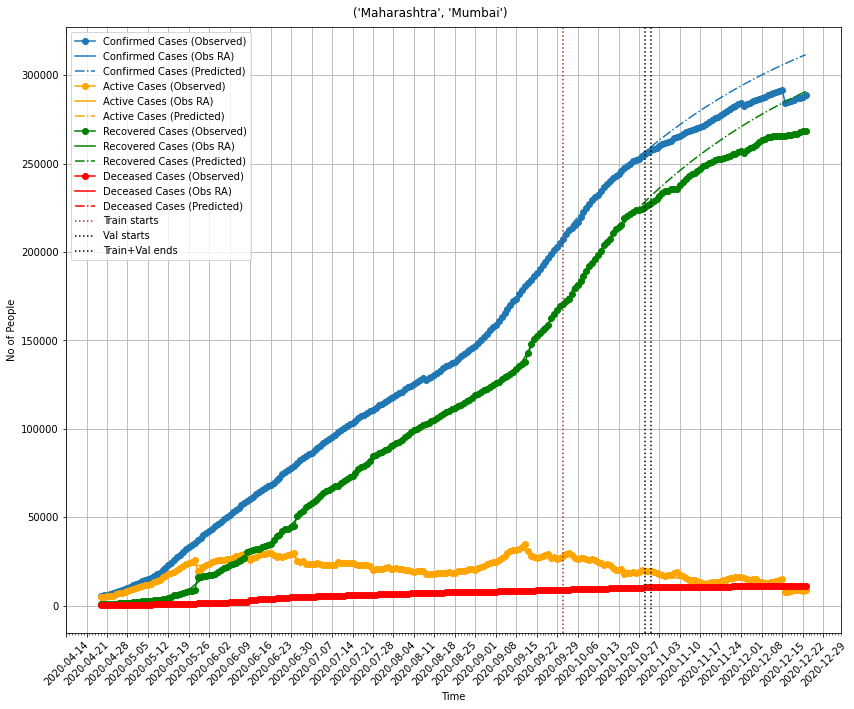

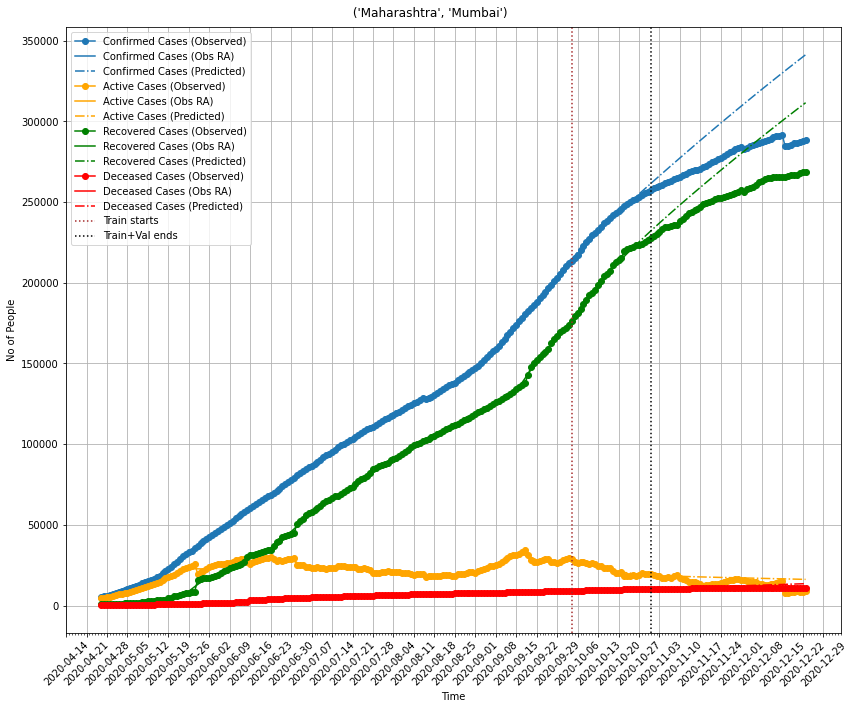

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting']))
m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = timestamp.strftime("%Y-%m-%d")

In [7]:
predictions_dict['m1']['best_params']

OrderedDict([('lockdown_R0', 0.9243590203146884),
             ('T_inc', 4.83590022940037),
             ('T_inf', 3.513477843806925),
             ('T_recov', 10.778933157863785),
             ('T_recov_fatal', 19.59637306249155),
             ('P_fatal', 0.025955214828337993),
             ('E_hosp_ratio', 0.14951749036936662),
             ('I_hosp_ratio', 0.42491255484264473),
             ('gamma', 0.012011072284738245)])

In [8]:
predictions_dict['m2']['best_params']

OrderedDict([('lockdown_R0', 1.0093171749369143),
             ('T_inc', 4.724637066505852),
             ('T_inf', 3.888637900604072),
             ('T_recov', 10.305706313969695),
             ('T_recov_fatal', 32.43483051288556),
             ('P_fatal', 0.04094612685746517),
             ('E_hosp_ratio', 0.08091234573909413),
             ('I_hosp_ratio', 0.43959528593079855),
             ('gamma', 0.012180245588249792)])

## Loss Dataframes

### M1 Loss DataFrame

In [9]:
predictions_dict['m1']['df_loss']

,train,val,test
total,0.40407,0.605254,2.43667
active,3.82922,8.90652,6.7874
recovered,0.624611,1.47704,2.88828
deceased,0.541094,0.529689,1.71579


### M2 Loss DataFrame

In [10]:
predictions_dict['m2']['df_loss']

,train,test
total,0.509024,4.60853
active,4.02308,17.1243
recovered,0.604213,3.93657
deceased,0.356396,5.18484


## Sensitivity Plot

100%|██████████| 101/101 [00:00<00:00, 102.36it/s]


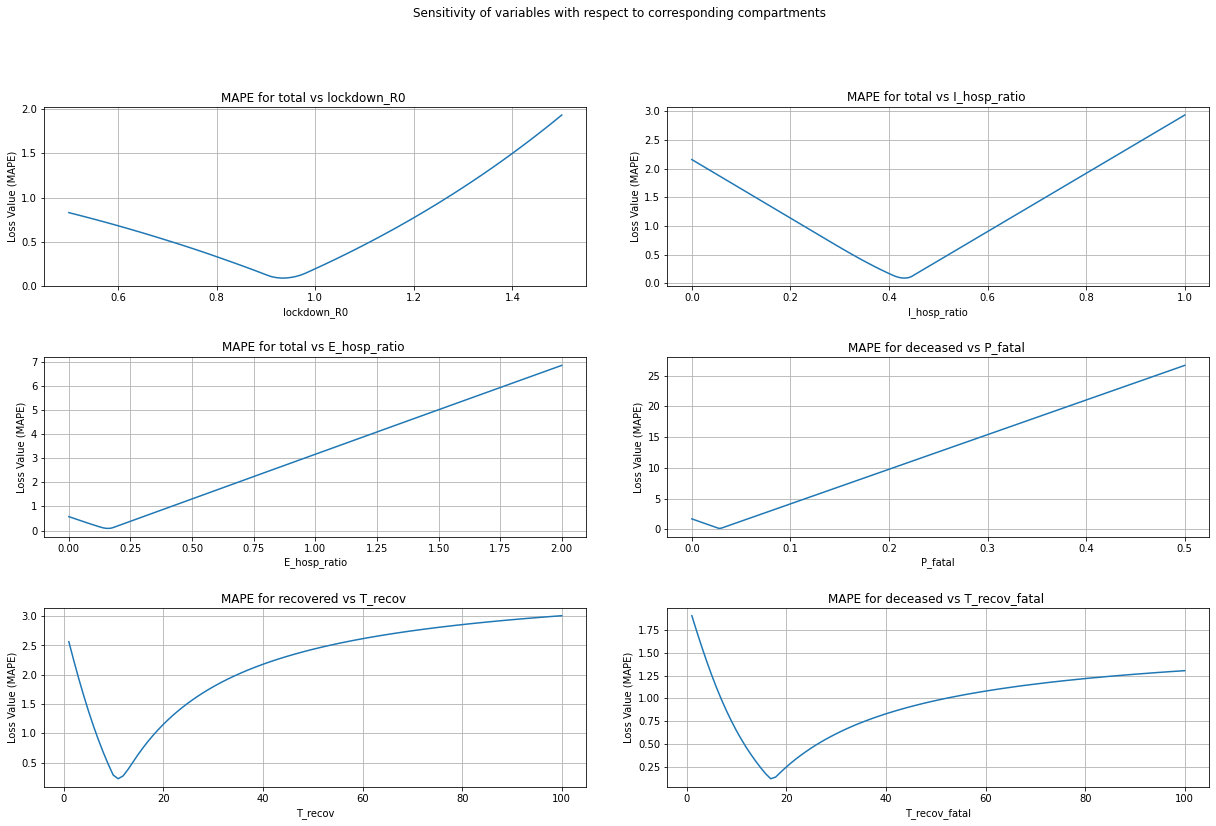

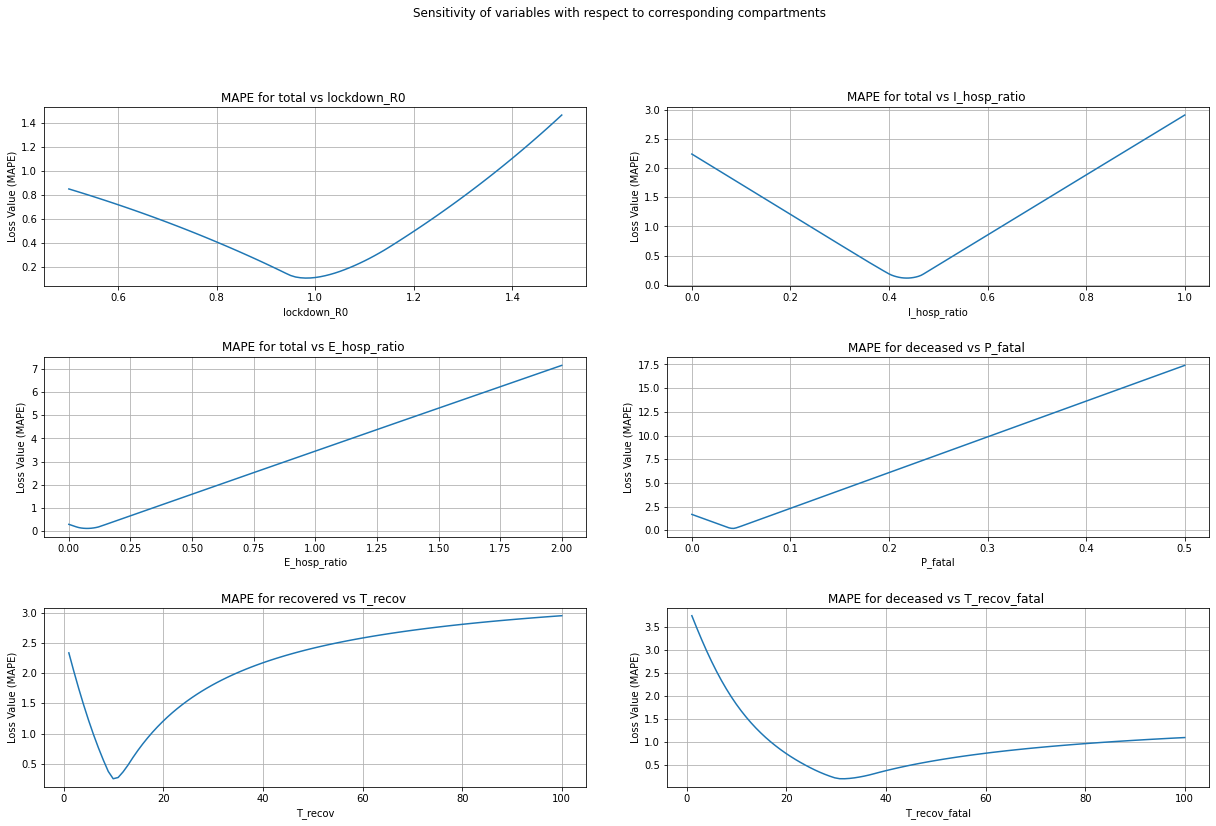

In [11]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

0it [00:00, ?it/s]

getting forecasts ..
getting forecasts ..


2000it [00:14, 137.17it/s]
14it [00:00, 137.73it/s]

getting forecasts ..


2000it [00:15, 133.25it/s]


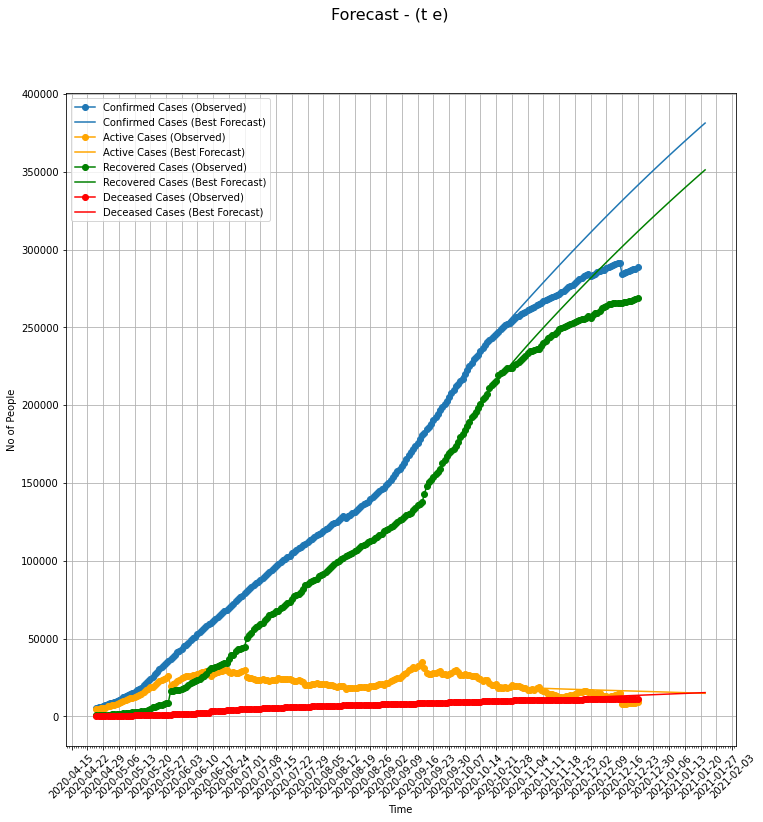

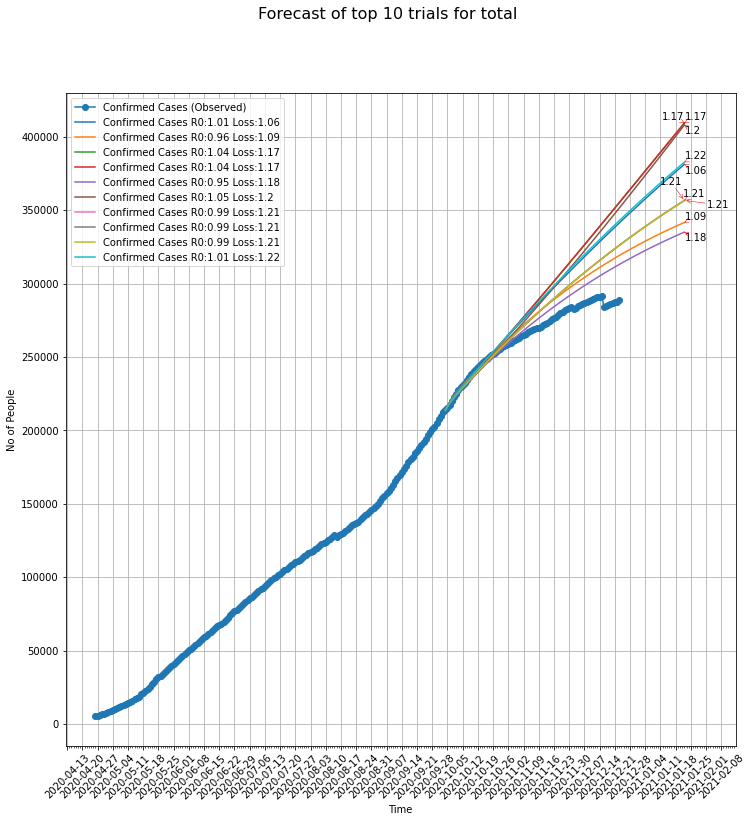

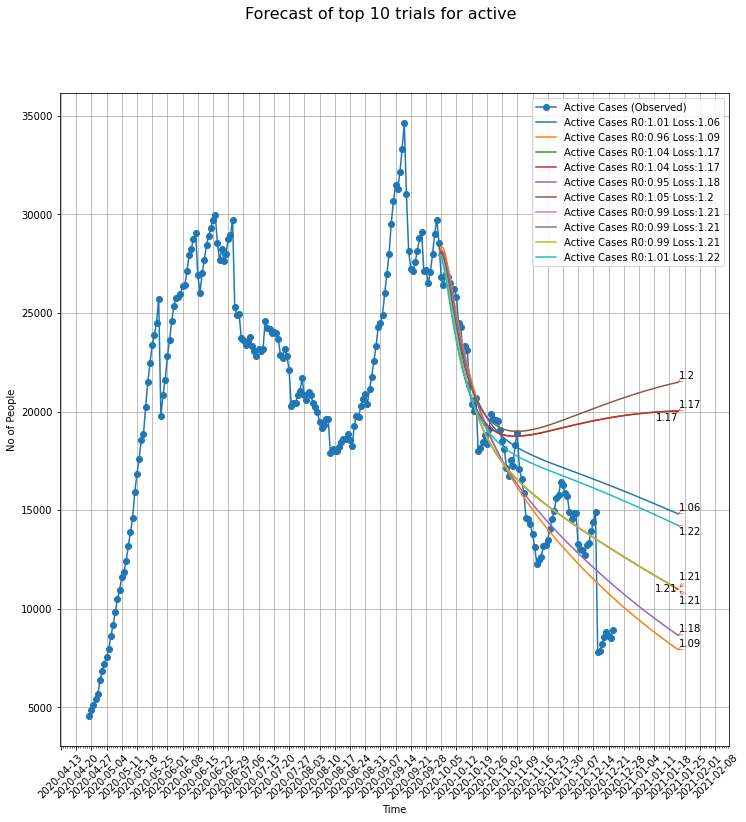

In [12]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 'test', 
                                                                 error_bars=False)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [33]:
uncertainty_args = {'predictions_dict': predictions_dict, 'fitting_config': config['fitting'],
                    'forecast_config': config['forecast'], **config['uncertainty']['uncertainty_params']}
                    
uncertainty = config['uncertainty']['method'](**uncertainty_args)

11it [00:00, 100.05it/s]

getting forecasts ..


2000it [00:15, 126.67it/s]


In [34]:
uncertainty.ensemble_mean_forecast['df_loss']

{'active': 16.468366455032342,
 'recovered': 1.9746533023179575,
 'deceased': 3.815378653491238,
 'total': 1.0153748334268375}

In [37]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [38]:
uncertainty_forecasts[2.5]['df_loss_perc']

,train,val,test
total,0.197002,0.33338,0.364003


In [39]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

ValueError: Could not interpret input 'date'

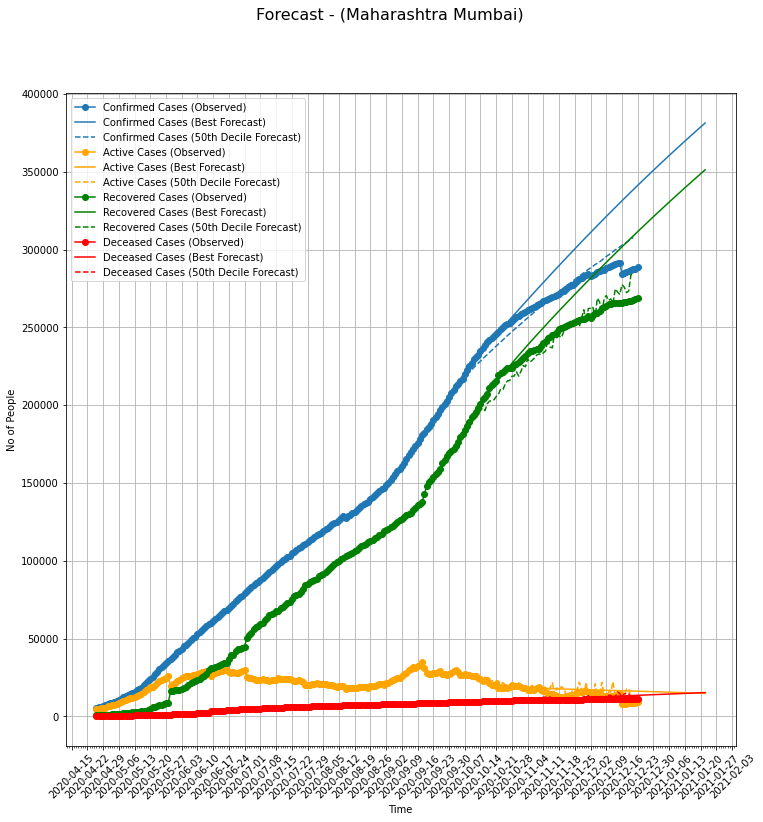

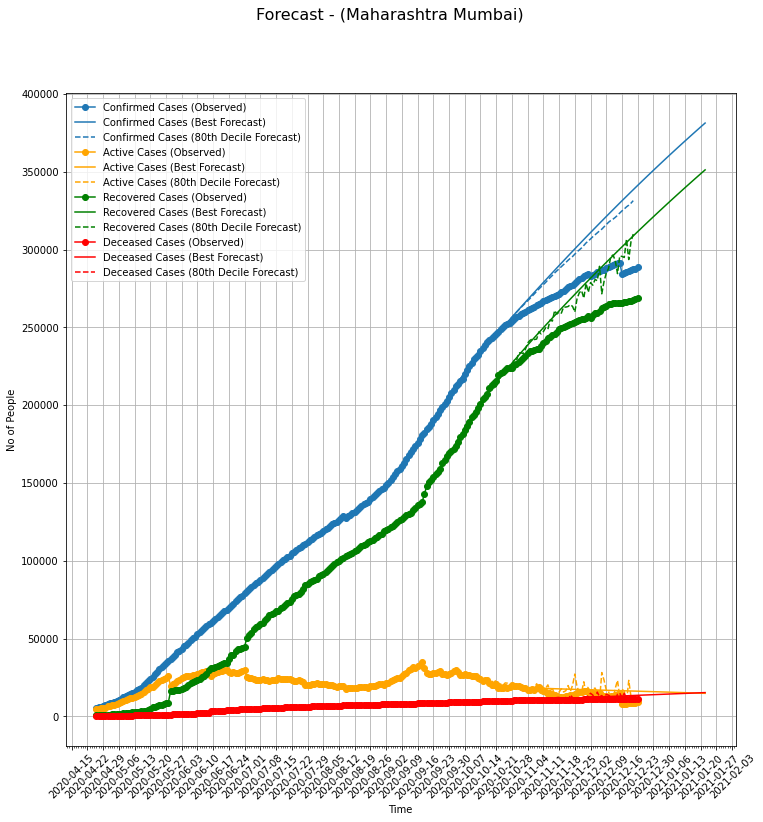

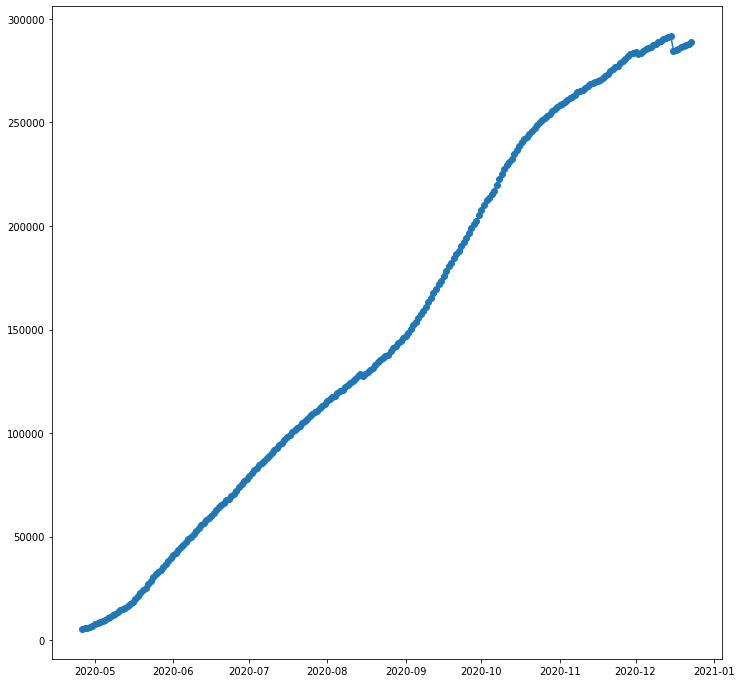

In [40]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

In [20]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Log on MLFlow

In [1]:
a = {1:[2,3],2:[3,4],3:[4,5]}
b = {1:[4,5],2:[5,6],3:[7,8]}

In [2]:
a.update(b)

In [3]:
a


{1: [4, 5], 2: [5, 6], 3: [7, 8]}

In [ ]:
log_mlflow(config['logging']['experiment_name'], run_name=config['logging']['run_name'], artifact_dir=output_folder)